In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db',isolation_level=None) as conn:
        return pd.read_sql(q,conn)

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level==None
        conn.execute(q)

def show_tables():
    q='''
    SELECT
        name,
        type
        
    FROM sqlite_master
    WHERE type IN ("table","view");
    
    '''
    return run_query(q)

show_tables()
        
    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
run_query('Select count(*) from track')

,count(*)
0,3503


In [22]:
genre_query=''' 
    with customer_usa as 
    (Select c.customer_id,c.country,il.track_id,i.invoice_id,il.quantity,
    il.invoice_line_id, il.quantity
    from customer c
    inner join invoice i on i.customer_id=c.customer_id
    inner join invoice_line il on il.invoice_id=i.invoice_id
    where c.country='USA'
    )
    Select 
    g.name as genre,
    count(cusa.invoice_line_id) tracks_sold,
    cast(count(cusa.invoice_line_id) as float)/
    (select count(*) from customer_usa) as percentage_sold
    
    from genre g
    inner join track t on g.genre_id=t.genre_id
    inner join customer_usa cusa on cusa.track_id=t.track_id
    group by 1 order by 2 desc
    limit 10
    '''
genre_sales_usa=run_query(genre_query)
genre_sales_usa

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


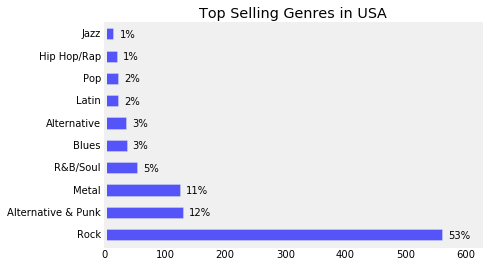

In [39]:
genre_sales_usa = run_query(genre_query)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in USA",
    xlim=(0, 625),grid=False,
    color='blue',alpha=0.65
    
)

plt.ylabel('')
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

In [43]:
query='''
select 
e.employee_id,e.first_name||" "||e.last_name as employee,
sum(i.total) as sales
from 
employee e
inner join customer c on e.employee_id=c.support_rep_id
inner join invoice i on c.customer_id=i.customer_id
group by 1
'''
employee_sales=run_query(query)
employee_sales

,employee_id,employee,sales
0,3,Jane Peacock,1731.51
1,4,Margaret Park,1584.00
2,5,Steve Johnson,1393.92


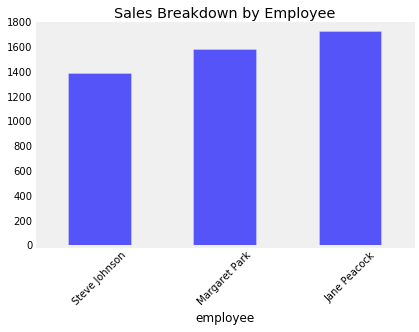

In [48]:
employee_sales = run_query(query)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("sales", inplace=True)
employee_sales["sales"].plot.bar(grid=False,
    legend=False,
    title='Sales Breakdown by Employee',
    color='blue',alpha=0.65,rot=45
)
plt.ylabel('')
plt.show()

In [6]:
run_query('''select
         c.country,sum(i.total),count(distinct(c.customer_id)),
         sum(i.total)/count(c.customer_id) as value_per_cust
    from invoice i 
    inner join customer c on i.customer_id=c.customer_id
    group by 1
    order by 2 desc
    ''')

,country,sum(i.total),count(distinct(c.customer_id)),value_per_cust
0,USA,1040.49,13,7.942672
1,Canada,535.59,8,7.047237
2,Brazil,427.68,5,7.011148
3,France,389.07,5,7.781400
4,Germany,334.62,4,8.161463
5,Czech Republic,273.24,2,9.108000
6,United Kingdom,245.52,3,8.768571
7,Portugal,185.13,2,6.383793
8,India,183.15,2,8.721429
9,Ireland,114.84,1,8.833846


In [7]:
q='''
with creating_table_country as 
( 
select 
    c.country as country,
    sum(i.total) as total_sales,
    count(distinct(c.customer_id)) as customers,
    sum(i.total)/count(c.customer_id) as value_per_cust
from invoice i 
inner join customer c on i.customer_id=c.customer_id
group by 1
order by 2 desc
)
select 
    country_name country,
    sum(customers) number_of_customers,
    sum(total_sales) total_sales,
    avg(value_per_cust) average_order
from 
    (select 
        ctc.*,
        case
            when ctc.customers<2 then 1
            else 0
        end as sort,
        case 
            when ctc.customers<2 then "Other"
            else ctc.country
        end as country_name
     from creating_table_country as ctc
    )
group by 1    
order by sort,2 desc

'''
sales_by_country=run_query(q)
sales_by_country

,country,number_of_customers,total_sales,average_order
0,USA,13,1040.49,7.942672
1,Canada,8,535.59,7.047237
2,Brazil,5,427.68,7.011148
3,France,5,389.07,7.781400
4,Germany,4,334.62,8.161463
5,United Kingdom,3,245.52,8.768571
6,Czech Republic,2,273.24,9.108000
7,India,2,183.15,8.721429
8,Portugal,2,185.13,6.383793
9,Other,15,1094.94,7.445071


#### Visualizing Sales by country

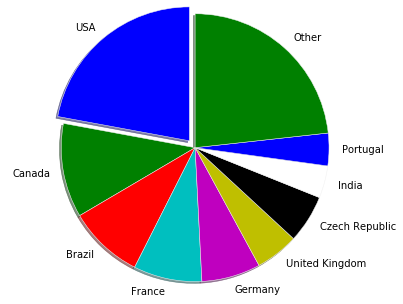

In [8]:
fig,ax=plt.subplots()
ax.axis('equal')
ex=[0]*len(sales_by_country["country"])
ex[0]=0.1
plt.pie(sales_by_country["total_sales"],
        explode=ex,
        labels=sales_by_country["country"],
        startangle=90,radius=1.5,shadow=True);

In [9]:
run_query('''select 
          count(distinct track_id),album_id from track
          group by album_id''')

,count(distinct track_id),album_id
0,10,1
1,1,2
2,3,3
3,8,4
4,15,5
5,13,6
6,12,7
7,14,8
8,8,9
9,14,10


In [10]:
run_query('''
with get_tracks as
(
    Select 
        i.invoice_id invoice_id,
        il.invoice_line_id,
        i.customer_id cus_id,
        
        t.track_id track_id,
        a.album_id album_id
        
    from invoice i
    inner join invoice_line il on i.invoice_id=il.invoice_id
    inner join track t on il.track_id=t.track_id
    inner join album a on a.album_id=t.album_id
)
select invoice_id,count(distinct track_id),album_id 
from get_tracks group by invoice_id,album_id
'''
)


,invoice_id,count(distinct track_id),album_id
0,1,16,91
1,2,1,20
2,2,1,34
3,2,1,39
4,2,1,66
5,2,1,73
6,2,1,134
7,2,1,190
8,2,1,215
9,2,1,218


In [11]:
q='''
with tracks_per_album as
(
select 
    count(distinct t.track_id) as num_of_tracks,
    a.album_id as album_id
from album a 
inner join track t on a.album_id=t.album_id 
group by 2
)
with get_tracks as
    (
    Select 
        i.invoice_id,
        i.customer_id,
        t.track_id as track_id,
        a.album_id as album_id
    from invoice i
    inner join invoice_line il on i.invoice_id=il.invoice_id
    inner join track t on il.track_id=t.track_id
    inner join album a on a.album_id=t.album_id
    )
select 
    invoice_id,
    album_id,
    count(distinct track_id) 
from get_tracks 
group by invoice_id,album_id
'''


In [13]:
q='''
with get_tracks as
    (
    Select 
        i.invoice_id invoice_id,
        i.customer_id,
        t.track_id as track_id,
        a.album_id as album_id
    from invoice i
    inner join invoice_line il on i.invoice_id=il.invoice_id
    inner join track t on il.track_id=t.track_id
    inner join album a on a.album_id=t.album_id
    ),

tracks_per_album as
    (
    Select 
        count(distinct t.track_id) as num_of_tracks,
        a.album_id as album_id
    from album a 
    inner join track t on a.album_id=t.album_id
    group by 2
    ),

categorization as 
(
select 
    invoice_id,
    case
        when 
        (select count(distinct track_id) 
        from get_tracks gt where gt.invoice_id=gt2.invoice_id
        group by album_id 
        except
        select num_of_tracks 
        from tracks_per_album tpa
        inner join get_tracks gt on tpa.album_id=gt.album_id        
        where gt.invoice_id=gt2.invoice_id
        group by gt.album_id) is null 
         
        AND
         
        (select num_of_tracks 
         from tracks_per_album tpa
         inner join get_tracks gt on tpa.album_id=gt.album_id        
         where gt.invoice_id=gt2.invoice_id
         group by gt.album_id 
         except
         select count(distinct track_id) 
         from get_tracks gt
         where gt.invoice_id=gt2.invoice_id
         group by album_id ) is Null then "Yes"
          
          else "No"
    end as album_purchase
    
from get_tracks gt2 group by 1
)
select 
    album_purchase,
    count(invoice_id) as number_of_invoices,
    cast(count(invoice_id) as float)/(select count(*) from categorization) as percentage
from categorization
group by 1


'''
run_query(q)

,album_purchase,number_of_invoices,percentage
0,No,500,0.814332
1,Yes,114,0.185668
